# CNN Visualizations 2 
Using multiple images from [Imagenette](https://github.com/fastai/imagenette)

## Get the data

In [1]:
import requests
import tarfile
from pathlib import Path

In [2]:
URL = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz"
FNAME = "imagenette2-320.tgz"
DATA = Path("data")
PATH = DATA/"imagenette2-320/train"

if not PATH.exists():
    with open(FNAME,"wb") as f:
        req = requests.get(URL)
        content = req.content
        f.write(content)
        tarfile.open(FNAME).extractall(DATA)

## Data prep

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset

In [5]:
np.random.seed(18)
count = 400
transf = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224)
])
ds = ImageFolder(PATH, transform=transf)
idx = np.random.choice(np.arange(len(ds)),count)
ds = Subset(ds, idx)

### Show me the data

In [6]:
"""
Helpers to show the images
"""

def splot(img, r=1, c=1, i=1, title=None):
    plt.subplot(r,c,i)
    plt.imshow(img)
    plt.axis('off')
    if title is not None:
        plt.title(title)

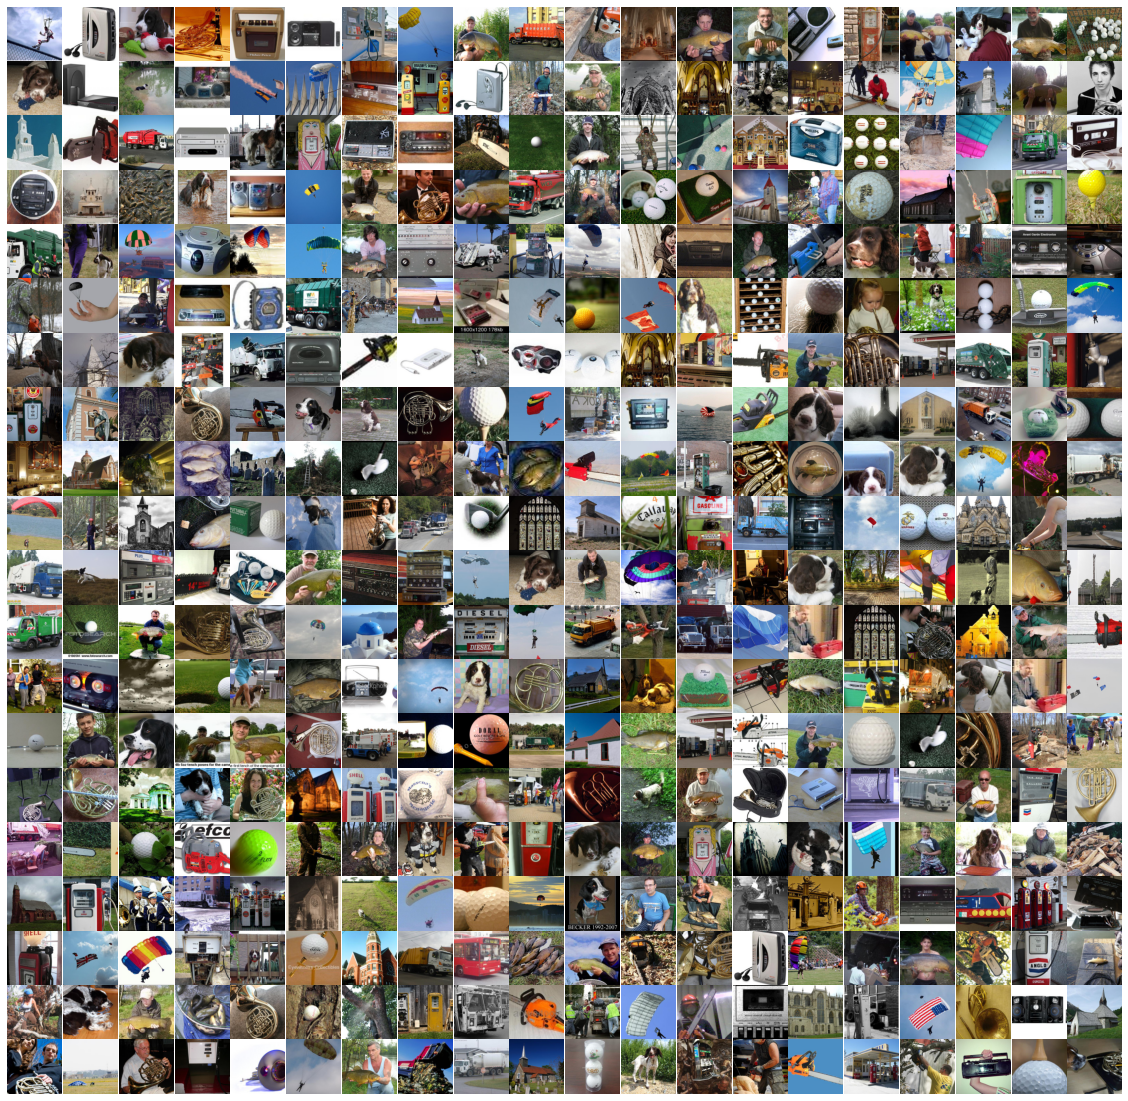

In [7]:
"""
What does the data look like??
"""

r = 20
c = 20
plt.figure(figsize=(20,20))
for i in range(r*c):
    splot(ds[i][0],r,c,i+1)
plt.subplots_adjust(wspace=0,hspace=0)

## Model Prep

In [8]:
import torch
from torchvision import models
from torchsummary import summary
from fitloop.helpers.utils import freeze

In [9]:
model = models.vgg19(pretrained=True)
# Getting rid of the aap and fc layers.
# Only feature extractors will be used for now.
model = [*model.children()][0] 
freeze(model)
with torch.no_grad():
    summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Doing Stuff

In [10]:
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name())

In [11]:
"""
Number of convlayers
"""
def get_layer_count(typ, model=model):
    l = 0
    for ch in model.children():
        if isinstance(ch, typ):
            l += 1
    return l
    
print("Conv2d layers: ".ljust(20), get_layer_count(nn.Conv2d))
print("ReLU activations: ".ljust(20), get_layer_count(nn.ReLU))
print("MaxPool2d layers: ".ljust(20), get_layer_count(nn.MaxPool2d))

Conv2d layers:       16
ReLU activations:    16
MaxPool2d layers:    5


- There are 37 layers in total in a VGG19 (the pure conv part of the network).
- The network is grouped into blocks where each block is an alternation between Conv2d and ReLU and delimited by MaxPool2d layers.
- The visualizations ahead will target specifically the outputs of the ReLU layers before the MaxPool2d layers, and the first ReLU.

## Helpers

In [17]:
"""
HELPERS TO DEAL WITH MODEL ACTIVATIONS
"""

def get_target_layer_indices(model=model):
    """
    Get indices of the layers before MaxPool2d
    and 1
    """
    idx = []
    for i,ch in enumerate(model.children()):
        if isinstance(ch, nn.MaxPool2d):
            idx.append(i)
    idx.insert(0,1)
    return idx

def get_activations(x, indices=0, model=model):
    """
    Get activations for `x` for the given indices
    can be a list or a single number
    """
    if not isinstance(indices,list):
        indices = [indices]
    indices = indices.copy()
    indices.sort()
    activations = []
    idx = indices.pop(0)
    
    model.eval().to(device)
    for i,ch in enumerate(model.children()):
        with torch.no_grad():
            x = ch(x.to(device))
        if i == idx:
            activations.append(x.detach().cpu().clone())
            try:
                idx = indices.pop(0)
            except IndexError:
                break
    return activations

In [13]:
"""
HELPERS TO DEAL WITH TRANSFORMS
"""
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

tt_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

def denorm(x):
    """
    Denormalizes input tensor
    of shape (batch,channels,width,height)
    """
    x *= std.reshape(1,3,1,1)
    x += mean.reshape(1,3,1,1)
    return x

def to_tensor(img):
    """
    Transforms PILs so that they 
    can be sent to the network.
    """
    img = tt_(img)
    return img.unsqueeze(0)

tt = to_tensor
dn = denorm

In [104]:
"""
Other helpers
"""

def nth(arr, n):
    """
    Returns the nth item of a flattened sorted array.
    """
    if not isinstance(arr, np.ndarray):
        try:
            arr = arr.numpy()
        except:
            arr = np.array(arr)
    arr = arr.flatten().copy()
    arr.sort()
    return arr[n]

## Post helpers

In [16]:
print(f"Layers targeted: {get_target_layer_indices()}")

Layers targetted: [1, 4, 9, 18, 27, 36]


# Activating Patches

## Layer 1

In [68]:
"""
CONSTANTS
"""

CHNL = 16  # Number of channels to visualize.
NEUR = 9   # Number of neurons per channel to visualize.

In [167]:
"""
HELPERS
"""

def get_act(l, count, ds=ds):
    """
    Gets activations of layer `l` for the first `count` 
    images from the dataset `ds`.
    """
    act= []
    for i in range(count):
        act.append(get_activations(tt(ds[i][0]),l)[0])
    return torch.cat(act)

def highest_activating_channels_indices(act, m=CHNL):
    """
    Gets the indices of the m highest activating 
    channels, for channel selection.
    """
    means = act.mean(dim=(0,2,3)).numpy()
    return np.where(means >= nth(means,-m))[0]

def highest_activating_neuron_indices(act, n=NEUR):
    """
    Gets the indices of the m highest activating 
    channels, for channel selection.
    """
    indices = []
    # dim=0 is the batch size dimension
    act = act.mean(dim=0)
    for amap in act:
        indices.append(np.where(amap >= nth(amap,-n)))
        
    # m sets of n number
    return indices

def get_act_indices(count=10, l=1):
    """
    Calls the above functions for given
    layer and the first `count` ds items
    and returns the highest `CHNL` activating
    channels with the highes `NEUR` indices
    """
    acts = get_act(l, count)
    ch_idx= highest_activating_channels_indices(acts)
    acts = acts[:,ch_idx,:,:]
    nu_idx = highest_activating_neuron_indices(acts)
    return acts, nu_idx

In [168]:
act, nu_idx = get_act_indices()

## What to do in this notebook
1. Activating patches
    - Pass images through the network, get the activation maps for a layer. 
    - From *m* activation maps for a subset of the images select the *n* highest activating neurons.
    - For these *n* neurons figure out the activating patches and display them.
2. Deconv Networks
3. Saliency Maps
4. [Captum](https://captum.ai)